To cluster students based on their patterns in studying

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# Data Loading and Merging
# ============================

# 1. Load your CSV files into DataFrames
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# Count how many unique assessments exist for each module + presentation
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# Compute average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()  # or .sum() if you prefer total score
    .reset_index()
    .rename(columns={"score": "score"})
)

df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# 3.1 Merge total_assessments (on code_module + code_presentation)
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how="left"
)

# 3.2 Merge attempted_assessments & average_score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how="left"
)

# 3.3 Merge total_vle_clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how="left"
)

# Replace NaN with 0 if needed
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"] = df_merged["total_assessments"].fillna(0)
df_merged["score"] = df_merged["score"].fillna(0)  # if missing, assume 0 or handle differently
df_merged["total_vle_clicks"] = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment_completion_ratio safely
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# Filter out withdrawn
df_merged = df_merged[
    (df_merged["final_result"] != "Withdrawn") 
].copy()

# Create binary target (Pass/Distinction=1, Fail=0)
df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# Rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# ---------------------------
# Final DataFrame including module
# ---------------------------
df_final = df_merged[
    [
        "id_student",
        "code_module",            # <-- include the module feature here
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))


    id_student code_module  score Gender                Region  \
0        11391         AAA   82.0      M   East Anglian Region   
1        28400         AAA   66.4      F              Scotland   
3        31604         AAA   76.0      F     South East Region   
4        32885         AAA   54.4      F  West Midlands Region   
5        38053         AAA   68.0      M                 Wales   
6        45462         AAA   68.0      M              Scotland   
7        45642         AAA   72.4      F  North Western Region   
8        52130         AAA   71.4      F   East Anglian Region   
9        53025         AAA   78.0      M          North Region   
10       57506         AAA   74.0      M          South Region   

                            HLE Age group  Credit Distribution  \
0              HE Qualification      55<=                  240   
1              HE Qualification     35-55                   60   
3         A Level or Equivalent     35-55                   60   
4        

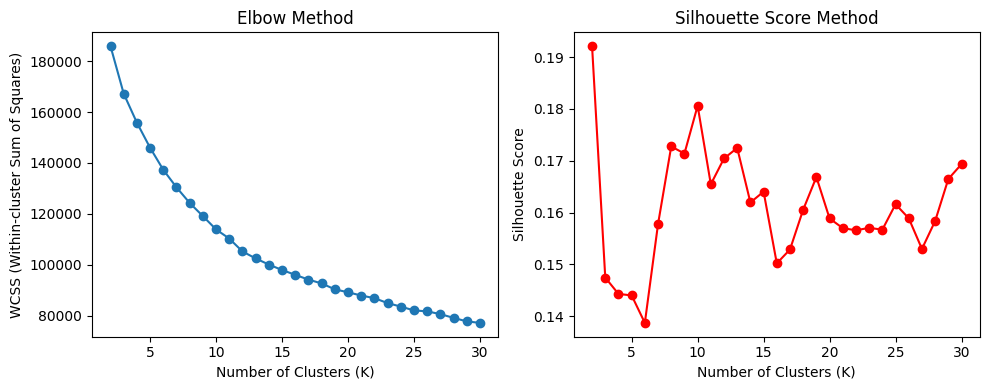

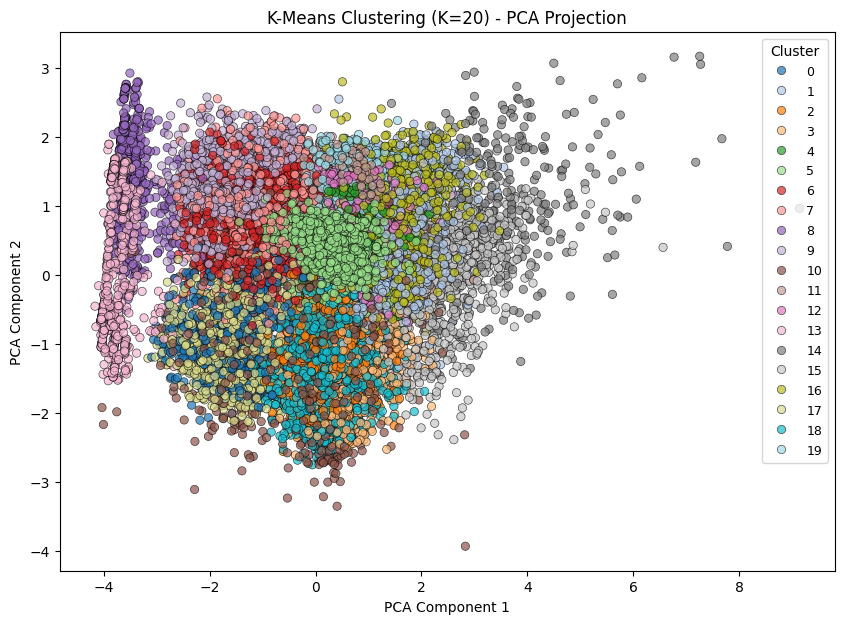

         code_module      score    Gender    Region       HLE  Age group  \
Cluster                                                                    
0           1.530850  65.659609  0.029104  2.365541  1.109430   0.294529   
1           4.628099  82.829565  0.610390  6.318772  0.695396   0.000000   
2           1.598629  75.074236  0.028941  2.083778  0.792841   0.000000   
3           1.313253  77.284883  0.000000  5.880120  0.930120   1.004819   
4           3.253149  77.714471  1.000000  8.700882  0.198363   0.001259   
5           5.865136  80.800879  0.000000  5.725251  1.208034   0.385940   
6           3.822706  65.585867  0.912908  6.009331  0.148523   0.000000   
7           3.811777  66.441381  0.776025  6.055731  1.197687   1.025237   
8           3.587432   2.520408  1.000000  6.080601  1.221311   0.245902   
9           4.358314  64.706827  0.808743  5.823575  2.032006   0.006245   
10          2.859594  70.887807  0.488300  5.993760  0.945398   0.230889   
11          

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ===========================
# Data Preprocessing
# ===========================

# Load your processed dataframe
df = df_final.copy()

# Drop student ID (not relevant for clustering)
df = df.drop(columns=['id_student'])

# Encode categorical variables
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

# Standardize features for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# ===========================
# Finding Optimal K (Elbow & Silhouette Method)
# ===========================

wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K_range = range(2, 31)  # Trying K from 2 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(df_scaled, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

plt.tight_layout()
plt.show()

# ===========================
# Applying K-Means with Optimal K
# ===========================

optimal_k = 20  # Change this based on elbow method & silhouette score analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# ===========================
# Visualizing Clusters using PCA (Better for 20 Clusters)
# ===========================

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(10, 7))

# Use a more distinct colormap
scatter = sns.scatterplot(
    x=df['PCA1'], y=df['PCA2'], hue=df['Cluster'], 
    palette="tab20", alpha=0.7, edgecolor="black"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (K={optimal_k}) - PCA Projection")

# Adjust legend for readability
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(9)  # Reduce font size for better visibility

plt.show()

# ===========================
# Display Cluster Statistics
# ===========================

print(df.groupby('Cluster').mean())  # Analyze the characteristics of each cluster


Calculate optimal eps

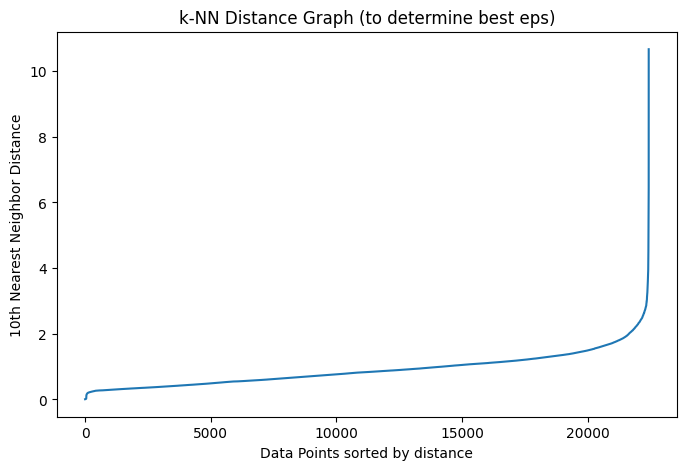

In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit NearestNeighbors model
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# Sort and plot k-distance graph
distances = np.sort(distances[:, 9], axis=0)  # 10th neighbor distance
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.title("k-NN Distance Graph (to determine best eps)")
plt.show()


DBScan

Number of Clusters found by DBSCAN: 24


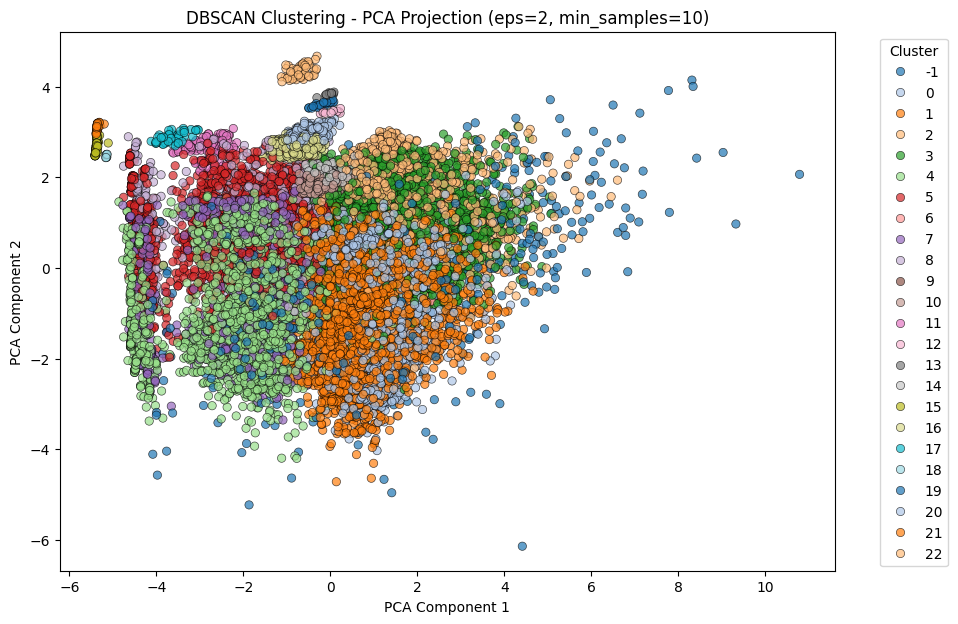

Number of noise points (outliers): 482


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ===========================
# Data Preprocessing
# ===========================

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['Cluster']))  # Exclude existing K-Means clusters

# ===========================
# Apply DBSCAN
# ===========================

# Tune parameters: eps (radius), min_samples (min points per cluster)
dbscan = DBSCAN(eps=2, min_samples=10)  # Adjust these values if needed
df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

# Count the number of unique clusters (DBSCAN assigns -1 to noise points)
num_clusters = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
print(f"Number of Clusters found by DBSCAN: {num_clusters}")

# ===========================
# Visualizing DBSCAN Clusters using PCA
# ===========================

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(10, 7))

# Plot DBSCAN clusters
sns.scatterplot(
    x=df['PCA1'], y=df['PCA2'], hue=df['DBSCAN_Cluster'], 
    palette="tab20", alpha=0.7, edgecolor="black"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"DBSCAN Clustering - PCA Projection (eps={dbscan.eps}, min_samples={dbscan.min_samples})")

# Adjust legend for readability
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# ===========================
# Check How Many Points Were Classified as Noise (-1)
# ===========================

num_noise = sum(df['DBSCAN_Cluster'] == -1)
print(f"Number of noise points (outliers): {num_noise}")


Now we add the profile/cluster as a new feature to re run our algos

In [16]:
# Add the DBSCAN cluster labels to the dataset
df_final['DBSCAN_Cluster'] = df['DBSCAN_Cluster']

# Convert cluster labels to categorical type (important for tree-based models)
df_final['DBSCAN_Cluster'] = df_final['DBSCAN_Cluster'].astype('category')

# Check new dataset with clusters
print(df_final.head())


   id_student code_module  score Gender                Region  \
0       11391         AAA   82.0      M   East Anglian Region   
1       28400         AAA   66.4      F              Scotland   
3       31604         AAA   76.0      F     South East Region   
4       32885         AAA   54.4      F  West Midlands Region   
5       38053         AAA   68.0      M                 Wales   

                     HLE Age group  Credit Distribution  \
0       HE Qualification      55<=                  240   
1       HE Qualification     35-55                   60   
3  A Level or Equivalent     35-55                   60   
4     Lower Than A Level      0-35                   60   
5  A Level or Equivalent     35-55                   60   

   assessment_completion_ratio  total_vle_clicks  target DBSCAN_Cluster  
0                     0.833333             934.0       1             -1  
1                     0.833333            1435.0       1              0  
3                     0.833333  

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ===========================
# Add DBSCAN Cluster Labels to Features
# ===========================
df_final['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].astype('category')  # Ensure categorical type

# Define features including DBSCAN cluster and module
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module', 'DBSCAN_Cluster'  # <-- Added DBSCAN cluster
]

X = df_final[features]
y = df_final['target']

# ===========================
# One-Hot Encode Categorical Features
# ===========================
X_encoded = pd.get_dummies(
    X, 
    columns=['Gender', 'Region', 'HLE', 'Age group', 'code_module', 'DBSCAN_Cluster'], 
    drop_first=True
)

# ===========================
# Create Sample Weights by Module
# ===========================
module_counts = df_final['code_module'].value_counts()
df_final['module_weight'] = df_final['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = df_final['module_weight']

# ===========================
# Split Data into Train & Test
# ===========================
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_encoded, y, sample_weights, test_size=0.25, random_state=42, stratify=y
)

# ===========================
# Define Models
# ===========================
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=3, bootstrap=True, 
                                            oob_score=True, class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42),
                                   n_estimators=100, random_state=42)
}

# ===========================
# Train and Evaluate Models
# ===========================
for model_name, model in models.items():
    print(f"\n====== {model_name} Performance ======\n")
    
    # Train model
    model.fit(X_train, y_train, sample_weight=w_train)
    
    # Predictions
    y_pred = model.predict(X_test)

    # General Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} Balanced Accuracy:", balanced_accuracy)
    print(f"{model_name} F1 Score:", f1)
    print(f"{model_name} Confusion Matrix:\n", cm)

    # Check Model Performance per Module
    print("\n--- Performance per Module ---")
    for module in df_final['code_module'].unique():
        module_indices = df_final[df_final['code_module'] == module].index
        X_module = X_test.loc[module_indices.intersection(X_test.index)]
        y_module = y_test.loc[module_indices.intersection(y_test.index)]
        
        if len(y_module) == 0:
            continue  # Skip if no test samples for this module
        
        y_pred_module = model.predict(X_module)
        acc_module = accuracy_score(y_module, y_pred_module)
        f1_module = f1_score(y_module, y_pred_module)
        
        print(f"Module {module}: Accuracy = {acc_module:.4f}, F1 Score = {f1_module:.4f}")

    # Special case: Print OOB Score for Random Forest
    if model_name == "Random Forest":
        print("\nRandom Forest OOB Score:", model.oob_score_)



====== Decision Tree Performance ======

Decision Tree Accuracy: 0.9647058823529412
Decision Tree Balanced Accuracy: 0.9507593411695598
Decision Tree F1 Score: 0.9746218918226096
Decision Tree Confusion Matrix:
 [[1610  153]
 [  45 3802]]

--- Performance per Module ---
Module AAA: Accuracy = 0.9732, F1 Score = 0.9847
Module BBB: Accuracy = 0.9648, F1 Score = 0.9750
Module CCC: Accuracy = 0.9257, F1 Score = 0.9461
Module DDD: Accuracy = 0.9550, F1 Score = 0.9653
Module EEE: Accuracy = 0.9573, F1 Score = 0.9714
Module FFF: Accuracy = 0.9845, F1 Score = 0.9888
Module GGG: Accuracy = 0.9821, F1 Score = 0.9867

====== Random Forest Performance ======

Random Forest Accuracy: 0.9723707664884136
Random Forest Balanced Accuracy: 0.9606499219065736
Random Forest F1 Score: 0.9801001412248043
Random Forest Confusion Matrix:
 [[1638  125]
 [  30 3817]]

--- Performance per Module ---
Module AAA: Accuracy = 0.9866, F1 Score = 0.9922
Module BBB: Accuracy = 0.9626, F1 Score = 0.9733
Module CCC: Acc

In [21]:
importances = clf_rf.feature_importances_
feature_names = X_encoded.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))  # Top 10 most important features


                        Feature  Importance
2   assessment_completion_ratio    0.267944
34             DBSCAN_Cluster_5    0.130535
0                         score    0.118822
32             DBSCAN_Cluster_3    0.117797
3              total_vle_clicks    0.088145
33             DBSCAN_Cluster_4    0.078793
30             DBSCAN_Cluster_1    0.062614
31             DBSCAN_Cluster_2    0.041166
37             DBSCAN_Cluster_8    0.025859
36             DBSCAN_Cluster_7    0.024333
